In [1]:
import pandas as pd

import time

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, lit
import pyspark.sql.functions as sf
from sim4rec.modules import Simulator
from pyspark.ml.classification import LogisticRegression, FMClassifier, RandomForestClassifier
from pyspark.ml import PipelineModel
from pyspark.sql import types as st

from replay.session_handler import State
from replay.models import RandomRec
from replay.metrics import NDCG, Precision, RocAuc

from sim4rec.utils import pandas_to_spark, VectorElementExtractor
from sim4rec.modules import RealDataGenerator, SDVDataGenerator
from sim4rec.modules import evaluate_synthetic, EvaluateMetrics
from sim4rec.response import ParametricResponseFunction, BernoulliResponse

from IPython.display import clear_output

from replay.models import UCB, ThompsonSampling

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

def calc_metric(response_df):
    return response_df.groupBy("user_idx").agg(sf.sum("response").alias("num_positive")).select(sf.mean("num_positive")).collect()[0][0]

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[*]')\
    .config('spark.sql.shuffle.partitions', '192')\
    .config('spark.default.parallelism', '192')\
    .config('spark.driver.memory', '256g')\
    .config('spark.driver.maxResultSize', '256g')\
    .getOrCreate()

State(spark)
spark.sparkContext.setLogLevel('ERROR')

24/05/25 10:54:31 WARN Utils: Your hostname, ecs-syudosaev-big resolves to a loopback address: 127.0.1.1; using 10.11.12.124 instead (on interface eth0)
24/05/25 10:54:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/05/25 10:54:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

user_svd = spark.read.csv('user_svd.csv', header=True, inferSchema=True)
item_svd = spark.read.csv('item_svd.csv', header=True, inferSchema=True)

users_df_train = spark.read.csv('train/users.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv('train/items.csv', header=True, schema=ITEM_SCHEMA).na.drop().drop('year')
log_df_val = spark.read.csv('val/rating.csv', header=True, schema=LOG_SCHEMA)

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.join(users_df_train, log_df_val['user_idx'] == users_df_train['user_idx'], 'leftsemi')
log_df_val = log_df_val.join(items_df_train, log_df_val['item_idx'] == items_df_train['item_idx'], 'leftsemi')

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') > 3, 1).otherwise(0))

log_df_val = log_df_val.cache()

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()

In [2]:
USER_SCHEMA = st.StructType(
    [st.StructField(f'uembed_{i}', st.DoubleType()) for i in range(128)] +\
    [st.StructField('user_idx', st.IntegerType())]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField(f'iembed_{i}', st.DoubleType()) for i in range(128)] +\
    [st.StructField('item_idx', st.IntegerType())]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

pca_users = spark.read.csv('user_svd.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv('item_svd.csv', header=True, schema=ITEM_SCHEMA)
log_df_val = spark.read.csv('val/rating.csv', header=True, schema=LOG_SCHEMA)

log_df_val = log_df_val.join(pca_users, log_df_val['user_idx'] == pca_users['user_idx'], 'leftsemi')
log_df_val = log_df_val.join(items_df_train, log_df_val['item_idx'] == items_df_train['item_idx'], 'leftsemi')

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') > 3, 1).otherwise(0))

log_df_val = log_df_val.cache()

In [3]:
va_users = VectorAssembler(
    inputCols=users_df_train.columns[1:],
    outputCol='features'
)
pca_u = PCA(k=9, inputCol="features")
pca_u.setOutputCol("pca_features")
model_users = pca_u.fit(va_users.transform(users_df_train))
print(sum(model_users.explainedVariance))

pca_users = model_users.transform(va_users.transform(users_df_train)).select(['user_idx', 'pca_features'])
pca_users = (pca_users.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_idx'] + [col('user_feature')[i].alias(f'user_feature_{i}') for i in range(9)])

0.9216818424353497


In [4]:
pca_users = pca_users.join(user_svd, on='user_idx', how='inner')
items_df_train = items_df_train.join(item_svd, on='item_idx', how='inner')

train_df = log_df_val.join(pca_users, 'user_idx', 'inner')\
                     .join(items_df_train, 'item_idx', 'inner')\
                     .drop('timestamp')

In [7]:
va = VectorAssembler(
    inputCols=pca_users.columns[1:] + items_df_train.columns[1:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)
fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)
lr_model = lr.fit(va.transform(train_df))
rf_model = rf.fit(va.transform(train_df))
fm_model = fm.fit(va.transform(train_df))

vee = VectorElementExtractor(inputCol='proba', outputCol='__r1', index=1)
mc = ParametricResponseFunction(inputCols=['__r1'], outputCol='__pr', weights=[0.25])
br = BernoulliResponse(inputCol='__pr', outputCol='response', seed=1234)
pipeline_lr = PipelineModel(stages=[va, lr_model, vee, mc, br])
pipeline_rf = PipelineModel(stages=[va, rf_model, vee, mc, br])
pipeline_fm = PipelineModel(stages=[va, fm_model, vee, mc, br])

In [8]:
ts_lr = ThompsonSampling(sample = True)
ts_lr.fit(log=log_df_val.drop('response').limit(1))

ts_rf = ThompsonSampling(sample = True)
ts_rf.fit(log=log_df_val.drop('response').limit(1))

ts_fm = ThompsonSampling(sample = True)
ts_fm.fit(log=log_df_val.drop('response').limit(1))

random_uni = RandomRec(distribution="uniform")
random_uni.fit(log=log_df_val.drop('response').limit(1))

In [9]:
evaluator = EvaluateMetrics(
    userKeyCol='user_idx',
    itemKeyCol='item_idx',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10, Precision() : 10, RocAuc(): 10}
)

users_generator = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)
users_generator.fit(pca_users.drop('user_id'))
items_generator.fit(items_df_train)
real_users = pca_users.sample(1.0)
syn_users = users_generator.generate(real_users.count())

In [10]:
def do_a_cycle(simul, model, pipeline, iteration, metrics):
    users = simul.sample_users(1.0).cache()
    log = simul.get_log(user_df=users)
    log = log_df_val.drop('response').limit(1) if log is None else log

    item_ids = items_df_train.select("item_idx").sample(0.2).cache()
    recs = model.predict(
        log,
        k=10,
        users=users.select("user_idx"),
        items=item_ids,
        filter_seen_items = False
    )
    resp = simul.sample_responses(
        recs_df=recs, 
        user_features=users,
        item_features=items_df_train,
        action_models=pipeline,
    ).select('user_idx', 'item_idx', 'relevance', 'response').cache()

    simul.update_log(resp, iteration=iteration)
    met = calc_metric(resp)
    ev = evaluator(resp)
    ev['CR'] = met
    metrics.append(ev)

    model._clear_cache()
    train_log = simul.log.cache()
    model.fit(train_log.select('user_idx', 'item_idx', 'response').withColumnRenamed('response', 'relevance'))

    log.unpersist()
    users.unpersist()
    recs.unpersist()
    resp.unpersist()
    train_log.unpersist()

sim_lr = Simulator(users_generator, items_generator, f'checkpoints/lr', None, 'user_idx', 'item_idx', spark)
sim_rf = Simulator(users_generator, items_generator, f'checkpoints/rf', None, 'user_idx', 'item_idx', spark)
sim_fm = Simulator(users_generator, items_generator, f'checkpoints/fm', None, 'user_idx', 'item_idx', spark)
sim_rand = Simulator(users_generator, items_generator, f'checkpoints/rand', None, 'user_idx', 'item_idx', spark)

lr_metrics = []
rf_metrics = []
fm_metrics = []
rnd_metrics = []

for i in range(50):
    print(f'------------------------Stage {i}------------------------')
    start_iter = time.time()

    do_a_cycle(sim_lr, ts_lr, pipeline_lr, i, lr_metrics)
    do_a_cycle(sim_rf, ts_rf, pipeline_rf, i, rf_metrics)
    do_a_cycle(sim_fm, ts_fm, pipeline_fm, i, fm_metrics)
    do_a_cycle(sim_rand, random_uni, pipeline_lr, i, rnd_metrics)
    # plot_metric(lr_metrics)
    clear_output(wait=True)
    end_iter = time.time()
    print(f"Time of {i+1} iteration: ")
    print(end_iter - start_iter)

Time of 50 iteration: 
181.9082374572754


In [11]:
import pickle
with open('records/lr_all_feats.pickle', 'wb') as f:
    pickle.dump(lr_metrics, f)
with open('records/rf_all_feats.pickle', 'wb') as f:
    pickle.dump(rf_metrics, f)
with open('records/fm_all_feats.pickle', 'wb') as f:
    pickle.dump(fm_metrics, f)
with open('records/rand_all_feats.pickle', 'wb') as f:
    pickle.dump(rnd_metrics, f)

(3.0, 7.0)

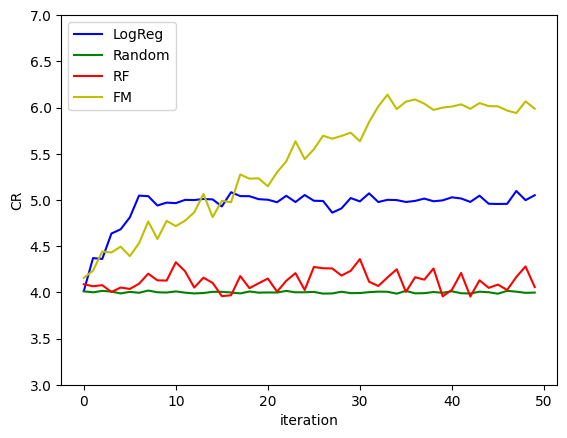

In [ ]:
metrics_lr = pd.DataFrame(lr_metrics)
metrics_rnd = pd.DataFrame(rnd_metrics)
metrics_rf = pd.DataFrame(rf_metrics)
metrics_fm = pd.DataFrame(fm_metrics)

plt.plot(metrics_lr['CR'], color='b')
plt.plot(metrics_rnd['CR'], color='g')
plt.plot(metrics_rf['CR'], color='r')
plt.plot(metrics_fm['CR'], color='y')
plt.xlabel('iteration')
plt.ylabel('CR')
plt.ylim(3, 7)
plt.savefig('ml_ndcg_new_users_base.png', dpi=300)